## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import ll_to_xy
import matplotlib.patheffects as pe
from netCDF4 import Dataset
from SPAEF_metric import SPAEF
from pyproj import CRS
from rasterio.enums import Resampling
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1. Simulation Data

In [3]:
variable = 'PRCP'
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

start_utc_era5 = 7
end_utc_era5 = 13

start_utc_gfs = 3
end_utc_gfs = 9

### 1.1 ERA5

#### 1.1.1 Data Options

In [4]:
run_data = 'era5'

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [5]:
data_path

['data/era5_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/era5_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.1.2 Open Data

In [6]:
# open data
dt = xr.open_mfdataset(data_path, combine='nested',
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

dt = dt.isel(time=slice(start_utc_era5, end_utc_era5))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_era5 = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

# sum over time dimension
#dt_era5_sum = dt_era5.sum(dim='time')

In [7]:
dt_era5

<xarray.DataArray 'PRCP' (ens: 6, time: 6, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(6, 6, 200, 200), dtype=float32, chunksize=(1, 6, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   Total precipitation rate
    units:         mm h-1
    stagger:       
    pyproj_srs:    +proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 ...
    coordinates:   XLONG XLAT XTIME
    grid_mapping:  spatial_ref

#### 1.1.3 Define Members

In [8]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

#### 1.1.4 Ensemble Mean For Urban and Nourban

In [9]:
#dt_era5_sum_urban_ens = dt_era5_sum.sel(ens=urban_members).mean(dim='ens')
dt_era5_urban_ens = dt_era5.sel(ens=urban_members)\
                           .mean(dim='ens')

In [10]:
dt_era5_urban_ens

<xarray.DataArray 'PRCP' (time: 6, south_north: 200, west_east: 200)>
dask.array<mean_agg-aggregate, shape=(6, 200, 200), dtype=float32, chunksize=(6, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

### 1.2 GFS

#### 1.2.1 Data Options

In [11]:
run_data = 'gfs' # gfs in normal

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [12]:
data_path

['data/gfs_LIN_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_LIN_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_THOMPSON_urban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_nourban_PRCP_wrfout_d03_2017-07-18.nc',
 'data/gfs_WSM6_urban_PRCP_wrfout_d03_2017-07-18.nc']

#### 1.1.2 Open Data

In [13]:
# open data
dt = xr.open_mfdataset(data_path, combine='nested',
                       concat_dim='ens')[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

dt = dt.isel(time=slice(start_utc_gfs, end_utc_gfs))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_gfs = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

# sum over time dimension
#dt_gfs_sum = dt_gfs.sum(dim='time')

In [14]:
dt_gfs

<xarray.DataArray 'PRCP' (ens: 6, time: 6, south_north: 200, west_east: 200)>
dask.array<getitem, shape=(6, 6, 200, 200), dtype=float32, chunksize=(1, 6, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18T03:00:00 ... 2017-07-18T08:...
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * ens          (ens) object 'LIN_nourban_PRCP' ... 'WSM6_urban_PRCP'
    spatial_ref  int64 0
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   Total precipitation rate
    units:         mm h-1
    stagger:       
    pyproj_srs:    +proj=lcc +lat_0=41.0720100402832 +lon_0=28.9729995727539 ...
    coordinates:   XLONG XLAT XTIME
    grid_mapping:  spatial_ref

#### 1.1.3 Ensemble Mean For Urban and Nourban

In [15]:
#dt_gfs_sum_urban_ens = dt_gfs_sum.sel(ens=urban_members).mean(dim='ens')
dt_gfs_urban_ens = dt_gfs.sel(ens=urban_members)\
                         .mean(dim='ens')

In [16]:
dt_gfs_urban_ens

<xarray.DataArray 'PRCP' (time: 6, south_north: 200, west_east: 200)>
dask.array<mean_agg-aggregate, shape=(6, 200, 200), dtype=float32, chunksize=(6, 200, 200), chunktype=numpy.ndarray>
Coordinates:
    lat          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    lon          (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    xtime        (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-07-18T03:00:00 ... 2017-07-18T08:...
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    spatial_ref  int64 0

### 1.3 IMERG

In [17]:
# define general path to datasets
data_source = 'imerg'
imerg_var = 'IRprecipitation'
general_path = f'data/observation/{data_source}/*20170718*'

# get individual data links
data_links = glob(general_path)
imerg = xr.open_mfdataset(data_links, use_cftime=True)

# adjust imerg units and turn it from 30 mins interval to 1 hour sums
imerg = imerg.resample(time = '1H',).sum()[imerg_var]
imerg = imerg.transpose('time', 'lat', 'lon')
imerg = imerg.isel(time=slice(start_utc_gfs,
                              end_utc_gfs))

#imerg_sum = imerg.sum(dim='time')
#imerg_sum = imerg_sum.rio.write_crs(CRS.from_epsg(4326))
#imerg_sum = imerg_sum.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

imerg = imerg.rio.write_crs(CRS.from_epsg(4326))
imerg = imerg.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

In [18]:
imerg

<xarray.DataArray 'IRprecipitation' (time: 6, lat: 150, lon: 150)>
dask.array<getitem, shape=(6, 150, 150), dtype=float32, chunksize=(1, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float32 20.05 20.15 20.25 20.35 ... 34.75 34.85 34.95
  * lat          (lat) float32 35.05 35.15 35.25 35.35 ... 49.75 49.85 49.95
  * time         (time) object 2017-07-18 03:00:00 ... 2017-07-18 08:00:00
    spatial_ref  int64 0

#### 1.3.1 Reproject Imerg to WRF

In [19]:
#print(da_to_be_matched.dims)
dt_match = dt_gfs_urban_ens.copy(deep=True)
dt_match = dt_match.rio.set_spatial_dims(x_dim='west_east', y_dim='south_north')

imerg_matched = imerg.rio.reproject_match(dt_match, 
                                                 Resampling.cubic_spline
                                                 )

In [20]:
imerg_matched

<xarray.DataArray 'IRprecipitation' (time: 6, y: 200, x: 200)>
array([[[ 5.5557933,  5.8643823,  6.3275995, ...,  0.       ,
          0.       ,  0.       ],
        [ 6.074563 ,  6.466317 ,  7.019349 , ...,  0.       ,
          0.       ,  0.       ],
        [ 6.608403 ,  7.0831065,  7.7253814, ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [19.69169  , 17.982523 , 16.51091  , ...,  0.       ,
          0.       ,  0.       ],
        [20.21348  , 18.465034 , 16.953585 , ...,  0.       ,
          0.       ,  0.       ],
        [20.736357 , 18.952547 , 17.404041 , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
...
        [15.704593 , 15.985545 , 16.255226 , ...,  4.50002  ,
          4.435048 ,  4.3995805],
        [15.707912 , 15.990501 , 16.261793 , ...,  4.254895 ,
          4.179979 ,  4.13326  ],
        [15.70353  , 15.988898 , 16.262857 , ...,  4.0253544,
          3.940837 ,  3.8830516]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 1.8268409,  1.8838547,  1.9343882, ..., 17.60875  ,
         16.507217 , 15.546052 ],
        [ 1.7863119,  1.8436831,  1.8947045, ..., 17.35023  ,
         16.27836  , 15.340743 ],
        [ 1.7379365,  1.7958974,  1.8477103, ..., 17.128551 ,
         16.083195 , 15.166374 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 -1.09e+05 -1.08e+05 -1.07e+05 ... 8.9e+04 9e+04
  * y            (y) float64 -1.09e+05 -1.08e+05 -1.07e+05 ... 8.9e+04 9e+04
  * time         (time) object 2017-07-18 03:00:00 ... 2017-07-18 08:00:00
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

## 2. Intra-Simulation Metric Calculation

### 2.1 Concat All Ensemble Members

In [21]:
era5_gfs_concat = np.concatenate([dt_era5.sel(ens=urban_members).values, 
                                  dt_gfs.sel(ens=urban_members).values])

In [22]:
np.shape(era5_gfs_concat)

(6, 6, 200, 200)

### 2.2 Concat Ensemble Mean

In [23]:
ens_era5_gfs_concat = np.concatenate([dt_era5_urban_ens.values[np.newaxis],
                                      dt_gfs_urban_ens.values[np.newaxis]])

In [24]:
np.shape(ens_era5_gfs_concat)

(2, 6, 200, 200)

### 2.3 Concat All Simulations

In [25]:
simulations = np.concatenate([
    era5_gfs_concat,
    ens_era5_gfs_concat
]) 

In [26]:
np.shape(simulations)

(8, 6, 200, 200)

### 2.4 Concat IMERG

In [30]:
imerg_and_simulations = np.concatenate([
    simulations,
    imerg_matched.values[np.newaxis]
]) 

In [31]:
np.shape(imerg_and_simulations)

(9, 6, 200, 200)

### 2.4 Calculate Metrics

In [32]:
# data used in simulation numpy array in order
simulation_data_order = [
    'era5-lin',
    'era5-thompson',
    'era5-wsm6',
    'fnl-lin',
    'fnl-thompson',
    'fnl-wsm6',
    'ens-era5',
    'ens-fnl',
    'imerg'
]

In [65]:
####### CHANGE HERE !!!!
# define for which hour the calculations will be made
hour_calc = 5 # 0 to 5
imerg_and_simulations_hourly = imerg_and_simulations[:, hour_calc, :, :]

In [66]:
spaef = np.zeros((9,9), dtype=np.float64)
corr = np.zeros((9,9), dtype=np.float64)
cv_ratio = np.zeros((9,9), dtype=np.float64)
histo_match = np.zeros((9,9), dtype=np.float64)

for i, s1 in enumerate(imerg_and_simulations_hourly):
    
    print(fr'next first data is {simulation_data_order[i]}')
    for j, s2 in enumerate(imerg_and_simulations_hourly):
        
        print(fr'>> next second data is {simulation_data_order[j]}')
        
        # spaef calculation
        SPAef, alpha, beta, gamma = SPAEF(s1, s2)
        
        spaef[i, j] = SPAef
        corr[i, j] = alpha
        cv_ratio[i, j] = beta
        histo_match[i, j] = gamma
        
        
    print('END ------------------')

next first data is era5-lin
>> next second data is era5-lin
>> next second data is era5-thompson
>> next second data is era5-wsm6
>> next second data is fnl-lin
>> next second data is fnl-thompson
>> next second data is fnl-wsm6
>> next second data is ens-era5
>> next second data is ens-fnl
>> next second data is imerg
END ------------------
next first data is era5-thompson
>> next second data is era5-lin
>> next second data is era5-thompson
>> next second data is era5-wsm6
>> next second data is fnl-lin
>> next second data is fnl-thompson
>> next second data is fnl-wsm6
>> next second data is ens-era5
>> next second data is ens-fnl
>> next second data is imerg
END ------------------
next first data is era5-wsm6
>> next second data is era5-lin
>> next second data is era5-thompson
>> next second data is era5-wsm6
>> next second data is fnl-lin
>> next second data is fnl-thompson
>> next second data is fnl-wsm6
>> next second data is ens-era5
>> next second data is ens-fnl
>> next second

In [67]:
df_spaef = pd.DataFrame(spaef, columns = [simulation_data_order],
             index = simulation_data_order)
df_corr = pd.DataFrame(corr, columns = [simulation_data_order],
             index = simulation_data_order)
df_cv_ratio = pd.DataFrame(cv_ratio, columns = [simulation_data_order],
             index = simulation_data_order)
df_histo_match = pd.DataFrame(histo_match, columns = [simulation_data_order],
             index = simulation_data_order)

### 2.5 Visual Metrics

In [68]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

df_spaef[mask] = np.nan
df_corr[mask] = np.nan
df_cv_ratio[mask] = np.nan
df_histo_match[mask] = np.nan

#### 2.5.1 SPAEF

[Text(0.5, 18.1111111111111, '')]

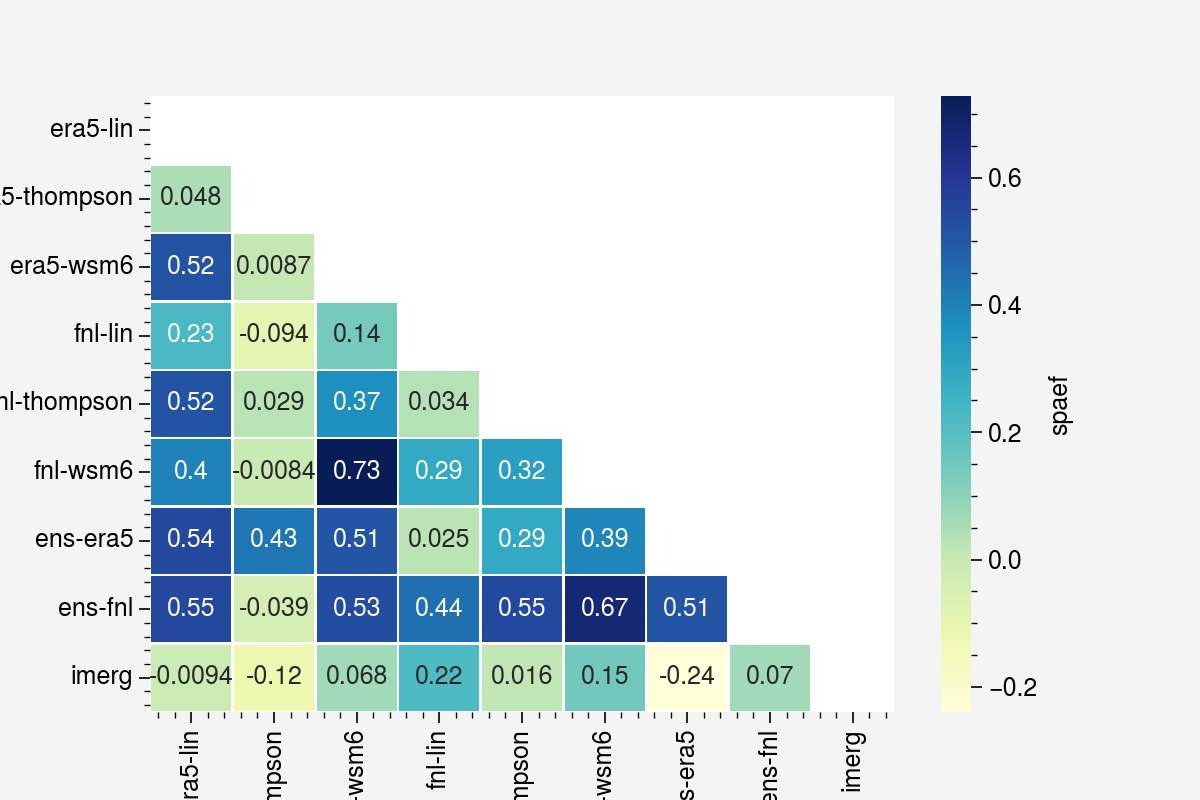

In [69]:
fig=plt.figure(figsize=(6,4))
s = sns.heatmap(df_spaef, 
            annot=True,
            linewidths=.5,
            cmap="YlGnBu",
            cbar_kws={'label': 'spaef'},
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values
           )
s.set(xlabel='')

#save figure
#plt.savefig(r'pictures/FigureS7.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

#### 2.5.2 CORR

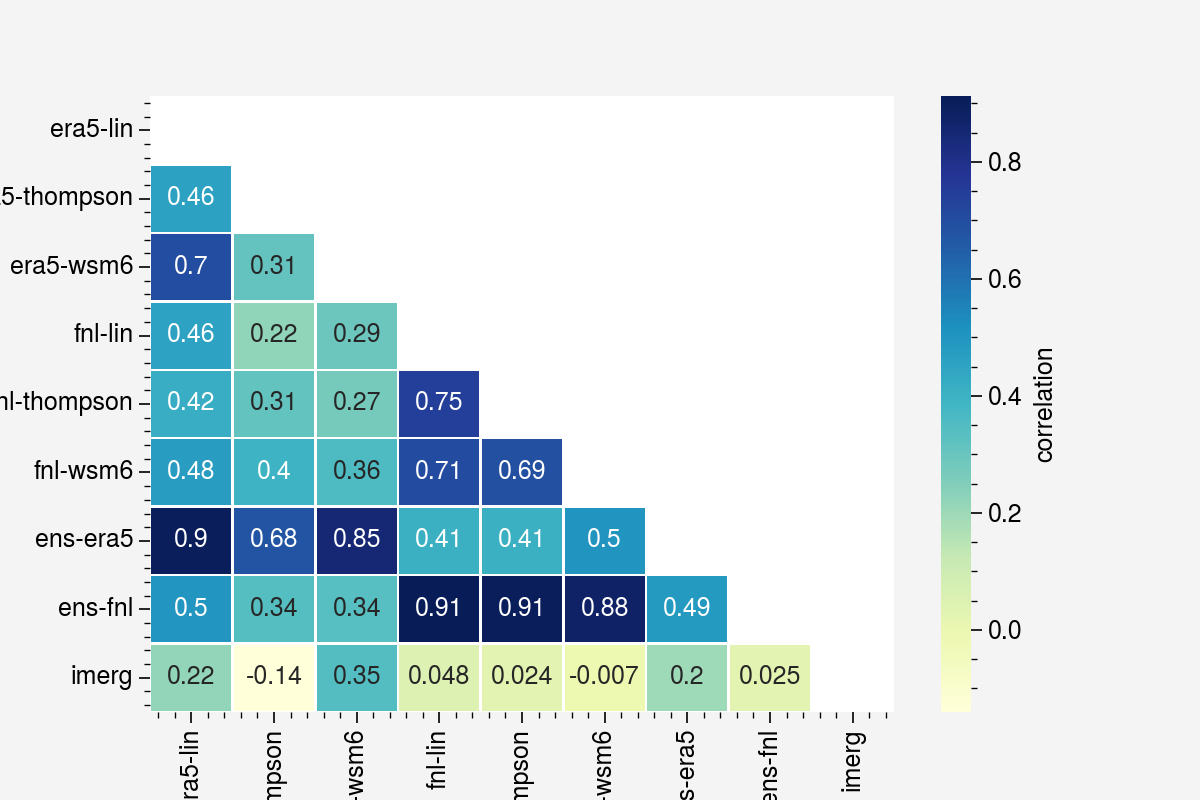

In [44]:
fig=plt.figure(figsize=(6,4))
s = sns.heatmap(df_corr, 
            annot=True,
            linewidths=.5,
            cmap="YlGnBu",
            cbar_kws={'label': 'correlation'}
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values
           )
s.set(xlabel='')

#save figure
#plt.savefig(r'pictures/combined_metric_corr.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

#### 2.5.3 CV

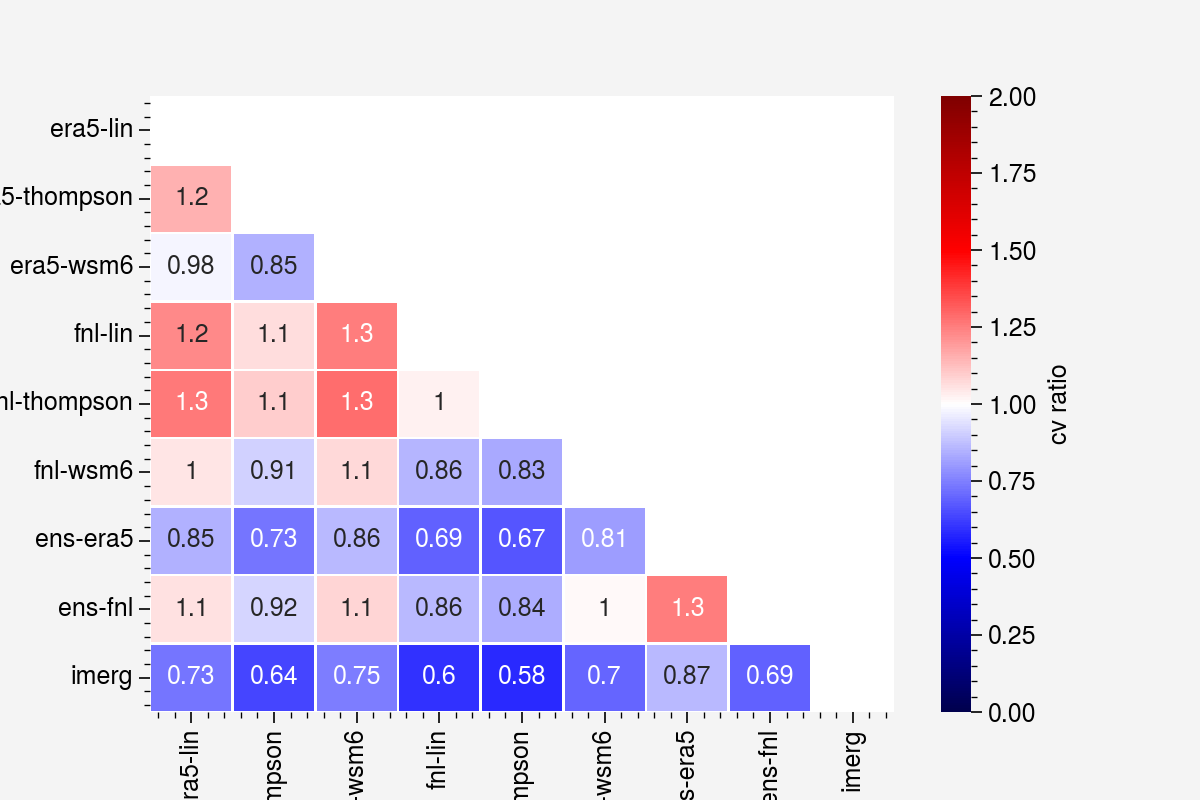

In [45]:
fig=plt.figure(figsize=(6,4))
s = sns.heatmap(df_cv_ratio, 
            annot=True,
            linewidths=.5,
            cmap="seismic",
            cbar_kws={'label': 'cv ratio'},
            vmin = 0,
            vmax = 2,
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values
           )
s.set(xlabel='')

#save figure
#plt.savefig(r'pictures/combined_metric_cvratio.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)

In [ ]:
fig=plt.figure(figsize=(6,4))
df_histo_match[mask] = np.nan
s = sns.heatmap(df_histo_match, 
            annot=True,
            linewidths=.5,
            cmap="YlGnBu",
            cbar_kws={'label': 'histo match'}
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values
           )
s.set(xlabel='')

#save figure
#plt.savefig(r'pictures/FigureS10.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=1000)